In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image
import os

import tensorflow as tf
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Распаковка данных

In [3]:
from zipfile import ZipFile

with ZipFile('/content/gdrive/MyDrive/train.zip', 'r') as zf:
    zf.extractall()
     
with ZipFile('/content/gdrive/MyDrive/train_masks.zip', 'r') as zf:
    zf.extractall()    

In [4]:
with ZipFile('/content/gdrive/MyDrive/test.zip', 'r') as zf:
    zf.extractall()   

In [5]:
#пути к файлам
file_path = '/content/train/'
file_mask_path = '/content/train_masks/'

In [6]:
file_test_path = '/content/test/'

In [7]:
train_img = sorted([os.path.join(file_path,i) for i in os.listdir(file_path)])
train_mask = sorted([os.path.join(file_mask_path,i) for i in os.listdir(file_mask_path)])

In [8]:
#порог для валидации
split_ratio = int(len(train_img) * 0.7)

In [9]:
#разбиение данных на трейн и тест
data = tf.data.Dataset.from_tensor_slices((np.array(train_img[:split_ratio]), np.array(train_mask[:split_ratio])))
data_val = tf.data.Dataset.from_tensor_slices((np.array(train_img[split_ratio:]), np.array(train_mask[split_ratio:])))

In [10]:
len(data)

3561

In [11]:
len(data_val)

1527

In [12]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def make_image(x,y):
    image = tf.io.read_file(x)
    image = tf.image.decode_png(image, channels=3) 
    image = tf.image.resize(image, (256, 256))
            
    mask = tf.io.read_file(y)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.image.resize(mask, (256, 256))
    mask = mask[:, :, :1]
    
    image, mask = normalize(image, mask)

    return image, mask

@tf.function
def data_augmentation(image, mask):
    if tf.random.uniform(()) > 0.5: 
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    return image, mask

In [13]:
data = data.map(make_image)
data_val = data_val.map(make_image)

In [14]:
data = data.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

Пример

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

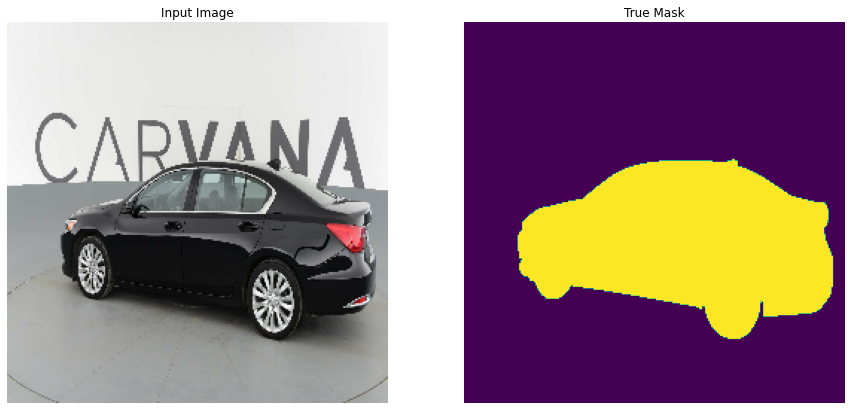

In [16]:
for image, mask in data.take(6):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

Подготовка модели

In [17]:
TRAIN_LENGTH = len(data)
BATCH_SIZE = 64
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


OUTPUT_CHANNELS = 1

In [18]:
train_dataset = data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = data_val.batch(BATCH_SIZE)

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [20]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [21]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3), # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [22]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
    output_channels, 3, strides=2, activation='sigmoid',
    padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [65]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coef(y_true, y_pred):
    smooth = 0.0001
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth)/ (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score 

def dice_loss(y_true, y_pred):
    smooth = 0.0001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth)/ (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return  1 - score

In [66]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='Adam',
              loss=dice_loss,
              metrics=[dice_coef])

Посмотрим на получившуюся архитектуру модели.

In [25]:
pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
%pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


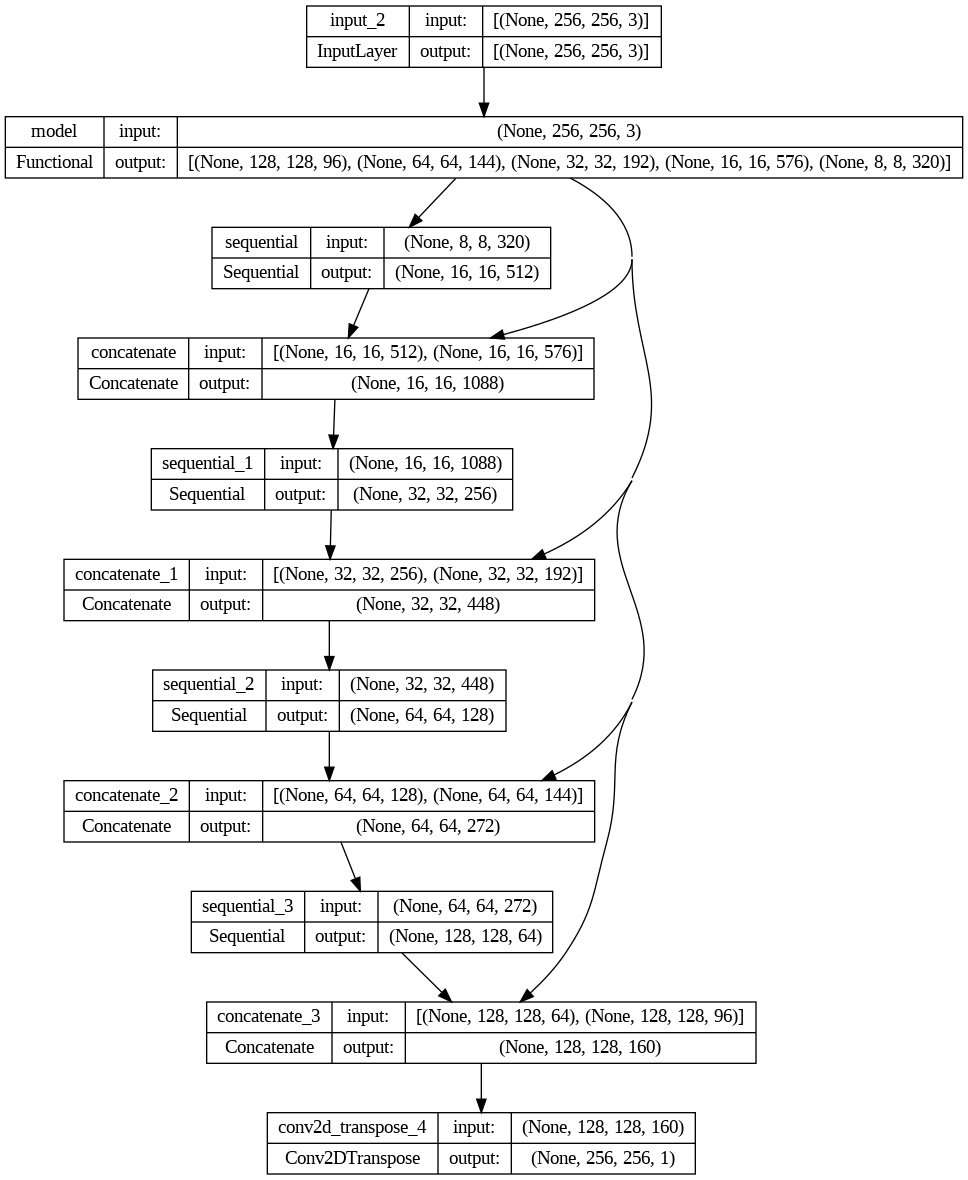

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break

1/1 [==============================] - 2s 2s/step


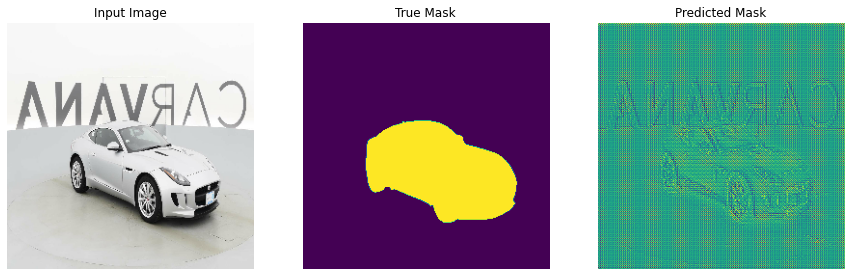

In [55]:
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(256,256,1)
    visualize([sample_image, sample_mask, pred_mask])
    
show_predictions(sample_image, sample_mask)


In [60]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=4,
                                                    restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            show_predictions(sample_image, sample_mask)

Epoch 1/5
 6/55 [==>...........................] - ETA: 21s - loss: 0.4019 - dice_coef: 0.8412

55/55 [==============================] - 77s 664ms/step - loss: 0.0819 - dice_coef: 0.9501 - val_loss: 0.0383 - val_dice_coef: 0.9612
Epoch 2/5
55/55 [==============================] - 34s 623ms/step - loss: 0.0316 - dice_coef: 0.9673 - val_loss: 0.0253 - val_dice_coef: 0.9753
Epoch 3/5
55/55 [==============================] - 30s 551ms/step - loss: 0.0203 - dice_coef: 0.9817 - val_loss: 0.0183 - val_dice_coef: 0.9873
Epoch 4/5
1/1 [==============================] - 2s 2s/step


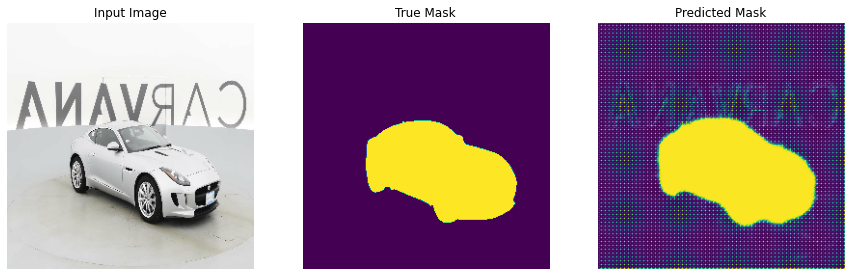

Epoch 5/5
55/55 [==============================] - 34s 619ms/step - loss: 0.0126 - dice_coef: 0.9891 - val_loss: 0.0142 - val_dice_coef: 0.9888


In [67]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(data_val)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

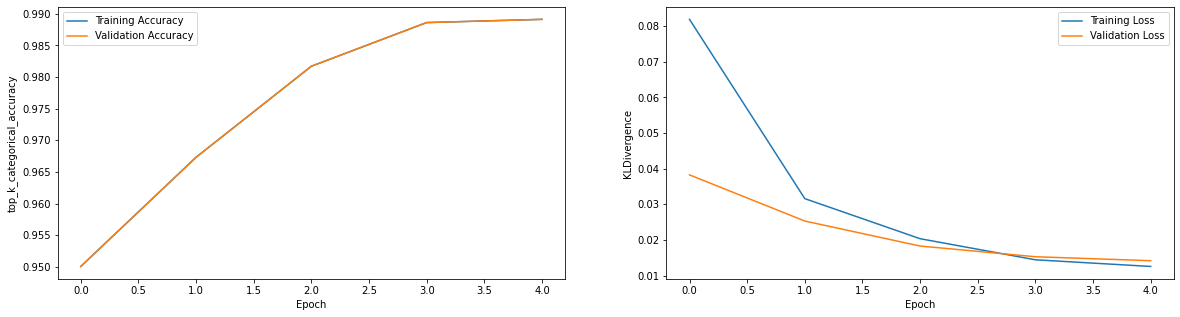

In [68]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

acc = model_history.history['dice_coef']
val_acc = model_history.history['dice_coef']

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('top_k_categorical_accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('KLDivergence')
plt.legend()
plt.show()

Предсказания

In [70]:
for images, masks in test_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break

1/1 [==============================] - 0s 29ms/step


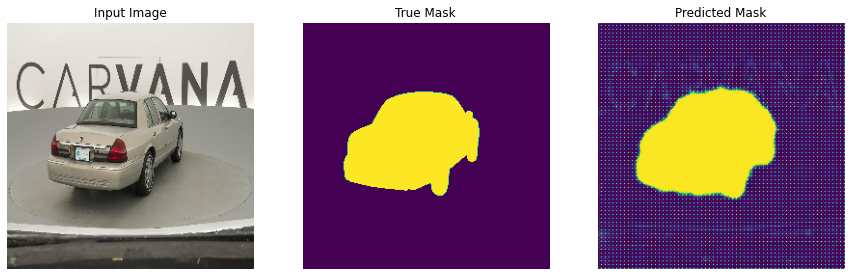

In [71]:
show_predictions(sample_image, sample_mask)